# 推特抢跑 Notebook 验证（v0.1.1）

本 Notebook 用于验证：推文 → AI 分析 → 交易对推断 → Binance 1m K 线展示 的完整流程。

- 同时展示推文 UTC 时间与本地时间（UTC+8）。
- AI 分析结果采用多行 JSON 格式输出，便于人工检查。
- 提供 `run_analysis(page: int)` 统一入口，快速切换不同推文。

In [33]:
# 配置与依赖加载
import json,os
from datetime import datetime, timedelta
from typing import Dict, Any, Optional, List

import requests
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# 解决 matplotlib 中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题


# Binance K 线配置
BINANCE_BASE_URL = "https://api.binance.com"
BINANCE_KLINES_PATH = "/api/v3/klines"
BINANCE_INTERVAL = "1m"
WINDOW_MINUTES = 15  # 推文时间前后各 15 分钟

# Notebook 默认页码（可在下方使用 run_analysis 覆盖）
TWEET_PAGE = 0  # 使用 latest.json 中的第几条推文（data["tweets"][page]）

TARGET_USER = "cz_binance"   # 默认抓取用户（不含@）
TWEET_LIMIT = 1              # 每次请求推文条数
REQUEST_INTERVAL_SEC = 5     # 请求间隔（固定5秒）


# Poe(OpenAI兼容)配置（如需使用 AI 分析）
AI_API_KEY = "bvJrIZp3bug_ZHHvkBTQmN_HanLRg-J6yEpRwAocESw"  # 示例 Key（建议改为环境变量）
AI_BASE_URL = "https://api.poe.com/v1"
AI_MODEL = "gpt-5.1"

# OpenAI 代理开关与配置（按需启用）
USE_OPENAI_PROXY = True  # 开关：True 使用下方代理，False 直连
OPENAI_PROXY = {
    "http": "http://localhost:1080",
    "https": "http://localhost:1080",
}

In [34]:

def read_text(path: str) -> str:
    """读取文本文件，返回内容。"""
    with open(path, "r", encoding="utf-8") as f:
        return f.read()


# -----------------------
# AI 分析（可选）
# -----------------------
def ai_analyze_text(text: str, author, introduction) -> str:
    # 允许通过函数参数或全局 USE_OPENAI_PROXY 控制是否走代理
    promot = read_text("提示词.txt")
    promot = promot.replace('{text1}', text)
    promot = promot.replace('{text2}', author)
    promot = promot.replace('{text3}', introduction)
    proxy = USE_OPENAI_PROXY
    try:
        import openai  # 延迟导入
        # 代理支持：优先使用 httpx 客户端方式；失败则回退到环境变量
        if proxy:
            try:
                from httpx import Client as _HttpxClient
                # 修正：httpx 的参数为 proxies（dict 或 str），不是 proxy
                http_client = _HttpxClient(proxies=OPENAI_PROXY, timeout=30.0)
                client = openai.OpenAI(api_key=AI_API_KEY, base_url=AI_BASE_URL, http_client=http_client)
            except Exception:
                import os as _os
                _os.environ["HTTP_PROXY"] = OPENAI_PROXY.get("http", "")
                _os.environ["HTTPS_PROXY"] = OPENAI_PROXY.get("https", "")
                client = openai.OpenAI(api_key=AI_API_KEY, base_url=AI_BASE_URL)
        else:
            client = openai.OpenAI(api_key=AI_API_KEY, base_url=AI_BASE_URL)

        chat = client.chat.completions.create(
            model=AI_MODEL,
            messages=[{"role": "user", "content": promot}],
            temperature=0.1,
            max_tokens=500,
        )
        # 兼容 openai 返回对象的两种可能结构
        content: Any = None
        if chat and getattr(chat, "choices", None):
            choice0 = chat.choices[0]
            msg = getattr(choice0, "message", None)
            if isinstance(msg, dict):
                content = msg.get("content")
            else:
                content = getattr(msg, "content", None)
        return content or "(AI 无内容返回)"
    except Exception as e:
        return f"(AI 跳过：{e})"


In [35]:
def load_single_tweet(path: str, page: int) -> Dict[str, Any]:
    """从 latest.json 中读取指定 page 的单条推文。
    - 结构遵循需求：data["tweets"][page]
    - 若顶层不是 dict，而是 list，则直接用 list[page]
    """
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    if isinstance(data, dict):
        tweets = data.get("tweets") or data
    else:
        tweets = data
    return tweets[page]


def parse_tweet_time(tweet: Dict[str, Any]) -> datetime:
    """将推文中的 createdAt 转为 UTC datetime 对象。
    示例格式："Thu Nov 13 16:25:19 +0000 2025"
    """
    created_at = tweet.get("createdAt") or tweet.get("created_at")
    return datetime.strptime(created_at, "%a %b %d %H:%M:%S %z %Y")


def to_local_time(dt_utc: datetime, offset_hours: int = 8) -> datetime:
    """将 UTC 时间转换为本地时间（默认 UTC+8）。"""
    return dt_utc + timedelta(hours=offset_hours)

In [36]:
def call_ai_for_tweet(text: str, author, introduction) -> Dict[str, Any]:
    """调用已有 ai_analyze_text，对推文文本做分析并尽量解析为 JSON dict。
    - use_proxy 为 None 时，沿用全局 USE_OPENAI_PROXY 行为
    - 若 AI 返回非严格 JSON，则包装为 {"raw": 原始字符串}
    """
    raw = ai_analyze_text(text, author, introduction)
    if not raw:
        return {"raw": "(空响应)"}
    try:
        return json.loads(raw)
    except Exception:
        return {"raw": raw}


def pretty_print_ai(ai_res: Dict[str, Any]) -> None:
    """人类友好的多行打印 AI 分析结果。"""
    if "raw" in ai_res and len(ai_res) == 1:
        print("[AI RAW]")
        print(ai_res["raw"])
        return
    try:
        print("[AI JSON]")
        print(json.dumps(ai_res, ensure_ascii=False, indent=2))
    except Exception:
        print("[AI RAW/FALLBACK]")
        print(ai_res)

In [ ]:

def normalize_symbol_from_ai(ai_res: Dict[str, Any]) -> Optional[str]:
    """从 AI 结果中提取交易币种并映射为 Binance 现货 symbol。"""
    raw_symbol = ai_res.get("交易币种")
    print('raw_symbol',raw_symbol)
    if isinstance(raw_symbol, list) and raw_symbol:
        first = str(raw_symbol[0]).upper()
    elif isinstance(raw_symbol, str) and raw_symbol.strip():
        first = raw_symbol.strip().upper()
    else:
        return None
    base = first.replace("USDT", "").replace("/", "").upper()
    return base + "USDT"



def detect_trade_symbol(ai_res: Dict[str, Any]) -> Optional[str]:
    """综合 AI 输出与原始文本，推断最终可交易 symbol。
    - 优先 AI 输出
    - 其次文本关键词
    - 若仍无法确定，返回 None（视为不可交易）
    """
    if "raw" in ai_res and len(ai_res) == 1:
        ai_res = ai_res["raw"]
    symbol = normalize_symbol_from_ai(ai_res)
    return symbol


In [38]:
def fetch_binance_klines(symbol: str, center_time_utc: datetime,
                         minutes: int = WINDOW_MINUTES) -> List[List[Any]]:
    """获取 symbol 在 center_time 前后指定分钟窗口内的 1m K 线原始数据（使用 UTC 时间戳）。"""
    start = center_time_utc - timedelta(minutes=minutes)
    end = center_time_utc + timedelta(minutes=minutes)
    params = {
        "symbol": symbol.upper(),
        "interval": BINANCE_INTERVAL,
        "startTime": int(start.timestamp() * 1000),
        "endTime": int(end.timestamp() * 1000),
    }
    url = BINANCE_BASE_URL + BINANCE_KLINES_PATH
    resp = requests.get(url, params=params, timeout=10)
    resp.raise_for_status()
    return resp.json()


def format_klines(klines: List[List[Any]]):
    """将 Binance 原始 K 线转换为 (times, opens, highs, lows, closes)。
    times 使用本地时间（便于与本地 UTC+8 对齐）。
    """
    times, opens, highs, lows, closes = [], [], [], [], []
    for k in klines:
        ts = datetime.fromtimestamp(k[0] / 1000)
        times.append(ts)
        opens.append(float(k[1]))
        highs.append(float(k[2]))
        lows.append(float(k[3]))
        closes.append(float(k[4]))
    return times, opens, highs, lows, closes

In [39]:
def plot_candles(times, opens, highs, lows, closes,
                 tweet_time_local: datetime,
                 title: str = "",
                 tweet_time_utc: Optional[datetime] = None) -> None:
    """简单绘制 1m K 线并标出推文时间竖线。
    - X 轴：本地时间（通常为 UTC+8）
    - 图下方附加推文 UTC / 本地时间说明
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    for t, o, h, l, c in zip(times, opens, highs, lows, closes):
        color = "red" if c >= o else "green"
        ax.plot([t, t], [l, h], color=color, linewidth=1)
        ax.plot([t, t], [o, c], color=color, linewidth=4)

    ax.axvline(tweet_time_local, color="blue",
               linestyle="--", label="Tweet Time")

    if times:
        min_t, max_t = min(times), max(times)
        ax.set_xlim(min_t, max_t)

    ax.set_title(title)
    ax.set_xlabel("Time (Local, UTC+8)")
    ax.set_ylabel("Price")

    locator = mdates.AutoDateLocator()
    formatter = mdates.DateFormatter("%m-%d %H:%M")
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    plt.legend()

    if tweet_time_utc is not None:
        info = (
            f"Tweet UTC: {tweet_time_utc.strftime('%Y-%m-%d %H:%M:%S %z')}\n" 
            f"Tweet Local (UTC+8): {tweet_time_local.strftime('%Y-%m-%d %H:%M:%S')}"
        )
        plt.figtext(0.01, -0.02, info, ha="left", va="top", fontsize=8)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

In [40]:
def run_analysis(page: int, json_path=None, author=None, introduction=None) -> None:
    """统一入口：分析 data["tweets"][page] 的完整链路。"""
    global TWEET_PAGE
    TWEET_PAGE = page
    print(f"[RUN] 分析 data['tweets'][{page}]")
    tweet = load_single_tweet(json_path, page)
    tweet_text = tweet.get("text") or tweet.get("full_text") or ""
    tweet_time_utc = parse_tweet_time(tweet)
    tweet_time_local = to_local_time(tweet_time_utc, 8)

    print("[TWEET ID   ]", tweet.get("id"))
    print("[CREATED UTC]", tweet.get("createdAt"))
    print("[CREATED CN ]", tweet_time_local.strftime("%Y-%m-%d %H:%M:%S (UTC+8)"))
    # print("[TEXT       ]", tweet_text)
    
    ai_result = call_ai_for_tweet(str(tweet), author, introduction)
    print(f"[AI RESULT  ]{type(ai_result), ai_result}")
    pretty_print_ai(ai_result)

    base_symbol = detect_trade_symbol(ai_result)
    symbol = base_symbol

    direction = ai_result.get("交易方向") or ai_result.get("direction")
    confidence = ai_result.get("消息置信度") or ai_result.get("confidence")

    print("[BASE SYMBOL]", base_symbol)
    print("[SYMBOL     ]", symbol)
    print("[DIRECTION  ]", direction)
    print("[CONF       ]", confidence)

    if symbol is None:
        print("[INFO] 无法确定交易对，视为不可交易，跳过 Binance K 线。")
    else:
        print(f"[INFO] 获取 {symbol} 在推文时间前后 {WINDOW_MINUTES} 分钟的 1m K 线…")
        try:
            raw_klines = fetch_binance_klines(symbol, tweet_time_utc)
            if not raw_klines:
                print("[WARN] 返回 K 线为空")
            else:
                t, o, h, l, c = format_klines(raw_klines)
                title = (
                    f"{symbol} 1m K 线（本地时间，含推文时间 "
                    f"{tweet_time_local.strftime('%Y-%m-%d %H:%M')}）"
                )
                plot_candles(
                    t, o, h, l, c,
                    tweet_time_local,
                    title=title,
                    tweet_time_utc=tweet_time_utc,
                )
        except Exception as e:
            print("[ERR] 获取或绘制 K 线失败:", e)

    summary = {
        "tweet_id": tweet.get("id"),
        "created_at_utc": tweet.get("createdAt"),
        "created_at_local": tweet_time_local.isoformat(),
        "symbol": symbol,
        "direction": direction,
        "confidence": confidence,
    }
    print("[SUMMARY]", summary)

[RUN] 分析 data['tweets'][0]
[TWEET ID   ] 1984992347395141987
[CREATED UTC] Sun Nov 02 14:33:49 +0000 2025
[CREATED CN ] 2025-11-02 22:33:49 (UTC+8)
[AI RESULT  ](<class 'dict'>, {'分析结果': '特定币种利好', '交易币种': ['ASTER/USDT'], '交易方向': 'long', '是否基于图片': '否', '分析依据': '推文来自 Binance 创始人 CZ（超强影响力 KOL），明确披露“我今天刚买了些 Aster，用的是我自己的钱，在 Binance 上。我不是交易员，我买入并长期持有”。这是非常典型的情绪喊单：顶级行业人物公开表示亲自买入并长期看好某个币种。该类信号在短线会显著提升市场关注度和买盘情绪，尤其是在其指出在 Binance 现货买入，说明流动性和交易入口都已就绪。虽然 CZ 强调自己“非交易员、偏长期持有”，但对短线价格依然构成实质利好，容易引发 FOMO 和跟随盘。没有提到负面事件或利空背景，因此可视为对 ASTER 的短期情绪利好，策略上偏向轻仓短线顺势做多（long），注意追高风险。本次属于情绪驱动而非链上或基本面事件驱动。', '预计涨跌幅': '5%-20%', '预期消息对市场行情影响的持续时间': '数小时-1天', '影响力强度': '95', '消息利好利空强度': '80', '消息置信度': '90', '消息中文翻译': '完全披露：我今天刚买了一些 Aster，用我自己的钱，在币安上。我不是交易员，我是买入并持有。'})
[AI JSON]
{
  "分析结果": "特定币种利好",
  "交易币种": [
    "ASTER/USDT"
  ],
  "交易方向": "long",
  "是否基于图片": "否",
  "分析依据": "推文来自 Binance 创始人 CZ（超强影响力 KOL），明确披露“我今天刚买了些 Aster，用的是我自己的钱，在 Binance 上。我不是交易员，我买入并长期持有”。这是非常典型的情绪喊单：顶级行业人物公开表示亲自买入并长期看好某个币种。该类信号在短线会显著提升市场关注度和买盘情

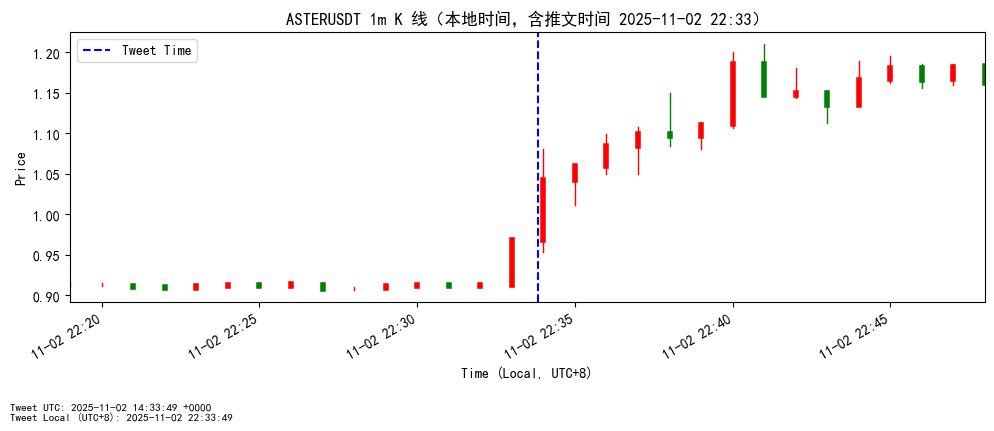

[SUMMARY] {'tweet_id': '1984992347395141987', 'created_at_utc': 'Sun Nov 02 14:33:49 +0000 2025', 'created_at_local': '2025-11-02T22:33:49+00:00', 'symbol': 'ASTERUSDT', 'direction': 'long', 'confidence': '90'}


In [41]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(0, "./twitter_media/1984992347395141987.json", 'cz_binance', 'BINANCE的创始人')

In [42]:
# 示例：运行第 0 条推文
# 后续你可以改成 run_analysis(1)、run_analysis(2) 等等
run_analysis(0, "./twitter_media/1987990314997739625.json", 'haydenzadams', '发明了Uniswap协议，创始人')

[RUN] 分析 data['tweets'][0]
[TWEET ID   ] 1987990314997739625
[CREATED UTC] Mon Nov 10 21:06:40 +0000 2025
[CREATED CN ] 2025-11-11 05:06:40 (UTC+8)
[AI RESULT  ](<class 'dict'>, {'raw': '{\n  "分析结果": "特定币种利好",\n  "交易币种": ["UNI/USDT"],\n  "交易方向": "long",\n  "是否基于图片": "否",\n  "分析依据": "本条消息由 Uniswap 创始人 Hayden Adams（项目最高权威之一）发布，影响力属于项目内最高级别。属于典型“事件利好 + 官方路线图级别更新”，而不是单纯情绪喊单。\\n\\n核心事件：\\n1）正式向 Uniswap 治理提交提案，拟“开启协议费并用于 UNI 销毁（burn）”。这等同于为 UNI 引入清晰的价值捕获机制，将协议收入直接反馈给代币，显著强化代币经济模型，通常被市场视为强利好。\\n2）Unichain sequencer 费用也将用于 UNI 销毁，进一步增加未来潜在销毁来源。\\n3）一次性从金库销毁 1 亿枚 UNI，用以“补偿”过去若从一开始就开协议费本可销毁的量，这是立即减少供应的强力通缩预期，极利好代币中短期价格表现。\\n4）介绍 Protocol Fee Discount Auctions、聚合器 hooks 等新机制，意在增强 LP 收益和将外部流动性协议费内生化到 Uniswap 协议，提高整个生态黏性和规模，为协议长期增长“铺路”，从基本面预期上偏大利好。\\n5）Labs 停止在界面、钱包、API 上收取费用，转而专注推动协议增长和采用，把更多价值主张和叙事集中到 Uniswap 协议与 UNI，同时将基金会员工并入 Labs，在治理和执行层面统一方向，强化“为 UNI 价值服务”的信号。\\n\\n事件性质：这是明确的代币经济升级与大规模销毁/价值捕获机制上线提案，属于重大链上/协议经济结构利好，不是纯情绪喊单。提案虽需治理通过，但由创始人+Labs+基金会核心人物共同推动，市场往往会提前 price in，很容易形成强短线拉升预期。\\n\\n'})